# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [1]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data

data x shape: (30000, 50, 6)
data y shape: (30000, 50, 1)


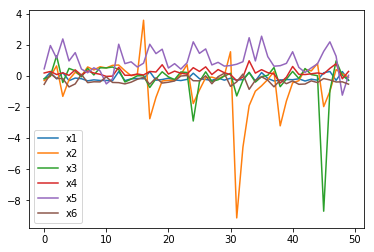

In [2]:
BATCH_SIZE=30000
TIME_SERIES_LENGTH = 50
OUTSIDE_VAR_COUNT = 6

# 요일 이펙트
def d1(x):
    return 1/(np.e * (x+0.023))

def d2(x):
    return -1/(x+0.02)

def d3(x):
    return 1/(x + 1.7)

def d4(x):
    return 2 + x/10

def d5(x):
    return  np.log(1/abs(x)) *  x

def create_data(batch_size=1000, time_series_length=500, moving_avg_n=1):
    funcs = [np.sin, np.cos, d1, d2, d3, d4, d5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, OUTSIDE_VAR_COUNT))
    y_data = np.zeros((batch_size, time_series_length, 1))

    for batch_idx in range(batch_size):
        ts_x = np.zeros((time_series_length, OUTSIDE_VAR_COUNT), dtype=np.float16)
        ts_y = np.zeros((time_series_length, 1))
        
        y1_prev, y2_prev, y3_prev, y4_prev, y5_prev, y6_prev = (0, 0, 0, 0, 0, 0)
        
        t = 0
        while t < time_series_length:
            x1 = np.random.rand(1)
            x2 = np.random.rand(1) * 0.1
            x3 = np.random.rand(1) * 0.5
            x4 = np.random.rand(1) * 1.2 + 0.5
            x5 = np.random.rand(1) * 1.5 + 2
            x6 = np.random.randn(1)
            
            if x1 > 0.8:
                x1 *= 2 + 0.5
                x2 *= 1.3 + 0.2
                x3 *= 0.5 + 1
                x4 *= 0.1 + 2
                x5 *= 1.5 + 1.2
            
            if x1 < 0.2:
                x2 += 2
                x3 += 3
                x4 = 1/x4
                x5 = 1/x5
                
            ts_x[t, 0] = x1
            ts_x[t, 1] = funcs[t%func_count](x2) + x2 + y2_prev * 0.5
            ts_x[t, 2] = funcs[t%func_count](x3) + x3 + y3_prev * 0.1
            ts_x[t, 3] = funcs[t%func_count](x4) + x4 + y4_prev * 0.2
            ts_x[t, 4] = funcs[t%func_count](x5) + x5 + y5_prev * 0.4
            ts_x[t, 5] = x6 + y6_prev * 0.1
            ts_y[t, 0] = funcs[t%func_count](x1) + x1 + y1_prev * 0.3
            y1_prev, y2_prev, y3_prev, y4_prev, y5_prev, y6_prev = ts_x[t].tolist()
            
            if np.isinf(ts_x[t]).any() or np.isnan(ts_x[t]).any():
                print('haha', ts_x[t], y5_prev)
                continue
            t += 1
            
        x_data[batch_idx, :] = ts_x
        y_data[batch_idx, :] = ts_y
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)


# Scaling X
x_shape = data_x.shape
scaler_x = StandardScaler()
data_x = scaler_x.fit_transform(data_x.reshape(-1, 1))
data_x = data_x.reshape(x_shape)

plot(data_x[0, :, 0], label='x1')
plot(data_x[0, :, 1], label='x2')
plot(data_x[0, :, 2], label='x3')
plot(data_x[0, :, 3], label='x4')
plot(data_x[0, :, 4], label='x5')
plot(data_x[0, :, 5], label='x6')
legend()

# Scaling Y
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

# Split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)

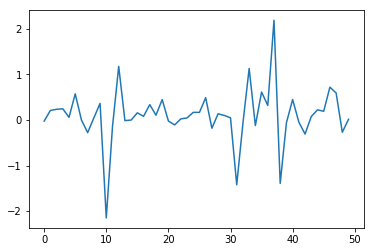

In [3]:
plot(data_y[0], label='y')

In [5]:
np.savetxt('train_x.txt', train_x.reshape(-1, OUTSIDE_VAR_COUNT), delimiter=',')
np.savetxt('train_y.txt', train_y.reshape(-1, 1), delimiter=',')
np.savetxt('test_x.txt', test_x.reshape(-1, OUTSIDE_VAR_COUNT), delimiter=',')
np.savetxt('test_y.txt', test_y.reshape(-1, 1), delimiter=',')

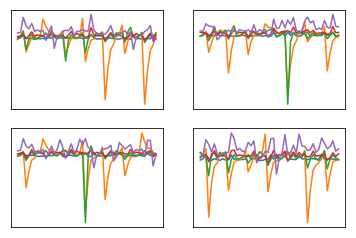

In [6]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
#             sample_y = data_y[batch_idx]
                                    
            sample_x1 = sample_x[:, 0]
            sample_x2 = sample_x[:, 1]
            sample_x3 = sample_x[:, 2]
            sample_x4 = sample_x[:, 3]
            sample_x5 = sample_x[:, 4]
        
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x1, label='x1')
            sp.plot(tick_x, sample_x2, label='x2')
            sp.plot(tick_x, sample_x3, label='x3')
            sp.plot(tick_x, sample_x4, label='x4')
            sp.plot(tick_x, sample_x5, label='x5')
            
visualize(data_x, data_y)

## Model

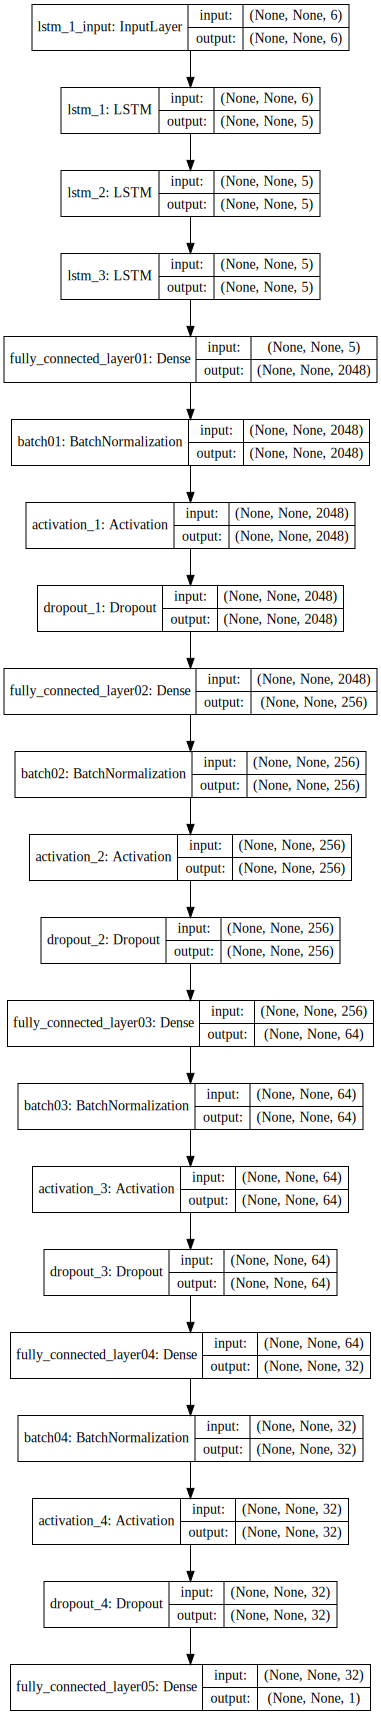

In [7]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=2048, dense2=256, dense3=64, dense4=32, 
                 optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, OUTSIDE_VAR_COUNT), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization(name='batch01'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense2, name='fully_connected_layer02'))
    model.add(BatchNormalization(name='batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense3, name='fully_connected_layer03'))
    model.add(BatchNormalization(name='batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(dense4, name='fully_connected_layer04'))
    model.add(BatchNormalization(name='batch04'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, name='fully_connected_layer05'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

In [ ]:
model = create_model(lstm_out1=200, lstm_out2=170, lstm_out3=None, dense1=2560, dense2=1536, dense3=512, 
                     dense4=256)
model.fit(train_x, train_y, verbose=2, epochs=3000)

Epoch 1/3000


error:0.5484769822715133, score:0.42908626319744336
score: 0.429086263197


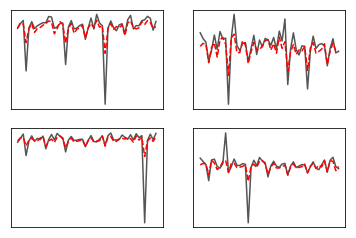

In [9]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red', linestyle='--')

visualize_prediction(test_x, test_y)

# Test

### test1

```
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

error:0.01373816696803562, score:0.9862618330319642
score: 0.986261833032
```